In [ ]:
# EMINEM - DATA GENERATION + MODEL BUILDING AND TRAINING

In [1]:
import requests # To make get calls to API
import matplotlib.pyplot as plt #used for 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup # Helps make parsing html files much easier
from functions import *
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
from tensorflow import keras 
from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# This token was granted through the use of Genius's website and allows us to make calls to the API
client_access_token = "_mDTViAvedsTbhpMuhLml-2gkMw1DU8tKQRnqmFkQDXT2aypVvCg67wDEr4eqBIs"

Using TensorFlow backend.


In [4]:
artist_name = 'Eminem'
songs = request_song_url(artist_name, 200)
lyrics = [""] * 200
index = 0
for song in songs:
    soup = BeautifulSoup(requests.get(song).content, 'lxml')
    lyrics[index] = ""

    for tag in soup.select('div[class^="Lyrics__Container"], .song_body-lyrics p'):

        for i in tag.select('i'):
            i.unwrap()
        tag.smooth()

        t = tag.get_text(strip=True, separator='\n')

        if t:
            lyrics[index]+=(t)
    print(index)
    index = index + 1

Found 200 songs by Eminem
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [5]:
for i in range(len(lyrics)):
        lyrics[i]= clean_lyrics(lyrics[i])
song = pd.DataFrame(lyrics)
song.columns = ['lyrics']
song.to_csv('eminem.csv', index=False)

In [6]:
data = pd.read_csv ('eminem.csv')
# print("Artists in the data:\n",data.artist_name.value_counts()) 


In [23]:
data["no_of_characters"] = data["lyrics"].apply(len)
data["no_of_words"]=data.apply(lambda row: nltk.word_tokenize(row["lyrics"]), axis=1).apply(len)
data["no_of_lines"] = data["lyrics"].str.split('\n').apply(len)
data.describe()

,no_of_characters,no_of_words,no_of_lines
count,200.000000,200.000000,200.000000
mean,4320.915000,1001.195000,109.705000
std,1260.801722,288.203981,31.083095
min,315.000000,87.000000,19.000000
25%,3653.000000,837.250000,92.000000
50%,4192.500000,973.500000,107.000000
75%,4935.500000,1127.750000,122.000000
max,11993.000000,2795.000000,326.000000


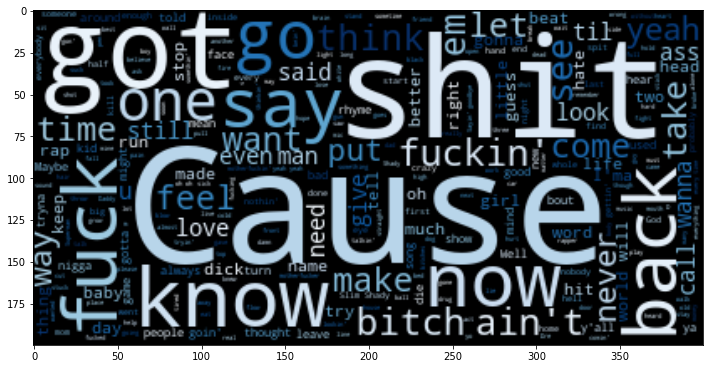

In [20]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#000000",colormap="Blues", max_words=800).generate(" ".join(data["lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [8]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 79


In [9]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '$', '%', '&', "'", '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '\xa0', 'à', 'á', 'â', 'ä', 'ç', 'è', 'é', 'í', 'ó', 'ö', 'ú', 'ü', 'ι', 'е', '\u2005', '\u200b', '–', '—', '‘', '’', '“', '”', '…', '\u2060']


In [10]:
Corpus = re.sub("[^A-Za-z0-9'\.\n]"," ",Corpus)

In [11]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', "'", '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
print(Corpus)


 look  i was gonna go easy on you not to hurt your feelings 
 but i'm only going to get this one chance 

 something's wrong  i can feel it 

 just a feeling i've got  like something's about to happen  but i don't know what.
if that means what i think it means  we're in trouble  big trouble 
and if he is as bananas as you say  i'm not taking any chances 
 you are just what the doc ordered 

i'm beginnin' to feel like a rap god  rap god
all my people from the front to the back nod  back nod
now  who thinks their arms are long enough to slap box  slap box 
they said i rap like a robot  so call me rap bot

but for me to rap like a computer it must be in my genes
i got a laptop in my back pocket
my pen'll go off when i half cock it
got a fat knot from that rap profit
made a livin' and a killin' off it
ever since bill clinton was still in office
with monica lewinsky feelin' on his nutsack
i'm an mc still as honest
but as rude and as indecent as all hell
syllables  skill a holic 
this flipp

In [13]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 864183
Number of unique characters: 40


In [14]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 864143


In [15]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [17]:
# model.save('429723.h5')

In [16]:
from tensorflow.keras.callbacks import LambdaCallback

In [17]:
import sys


# Q1: What is the purpose of this block? When is `char_indices` used? What about `indices_char`?
chars = sorted(list(set(Corpus)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Q2: What is the purpose of this block? What do the `seqlen` and `step` parameters do?
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(Corpus) - seqlen - 1, step):
    sentences.append(Corpus[i: i + seqlen + 1])

# Q3: What about this block? What is `x` and what is `y`? Why do they have this dimensionality?
x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    # Q3a: What happens in this loop?
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1


# Q4: Here we build the model. What does the `return_sequences` argument do? Why the dense layer at the end?
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(Corpus) - seqlen - 1)
    
    # Q5: What does diversity do?
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = Corpus[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            
            # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=300,
          callbacks=[print_callback])

Epoch 1/300
169/169 [==============================] - ETA: 0s - loss: 2.3342 - categorical_crossentropy: 2.3342 - accuracy: 0.3247
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "t like 
this white hot light
that i'm un"
t like 
this white hot light
that i'm un a star  the sere the should  but i  i'm the stor the back  i wan i wan i was i got i still the fuck the fuck the reall  i say  i still it the shit i  i'm the stor the shit  i still i  the like you  i'm the but i'm the still the ser the shit  i man  i was she fuckin' the sain the been i  i'm and it the shin  i don't know   here the shit in the shit i still a lit shit i got a mare the see  i'm and 
----- diversity: 0.5
----- Generating with seed: "t like 
this white hot light
that i'm un"
t like 
this white hot light
that i'm un in the onee a methar  shin i got is of your should
'cause i say the nack on i  i'm an the all get it the sain mant  chat is mare you like i 
me to shit hell a lond t

my name is a whole  i got a look at the game  i don't wanna see ya  did  get you the though
i don't want you to see
----- diversity: 1.0
----- Generating with seed: "yton  ohio
authorities say the shooter.."
yton  ohio
authorities say the shooter..

i think your lunked dut nig mane
that you're loaded for he lift
'cause we'll be your could if my primon lep hatazips
existors her mep
ain't feelin' your ass like it spit it
'cause you drove one  what you gon' cy remembers
taply's name through the splat te'va
say you're suspog just agains 
of life nothin' marman 
sive this brunaenop cetovion and that's had end 
don't even incenders a little mush 
169/169 [==============================] - 54s 322ms/step - loss: 1.4777 - categorical_crossentropy: 1.4777 - accuracy: 0.5446
Epoch 10/300
168/169 [============================>.] - ETA: 0s - loss: 1.4672 - categorical_crossentropy: 1.4672 - accuracy: 0.5482
----- Generating text after Epoch: 9
----- diversity: 0.2
----- Generating with seed: " put

pain meds  can't be your superman  you can see it  i knew it was the same shit  i say the shit  i got a complete to the day i was gonna see
the more the world was a star  it's like the street  i'm a criminal  i got a come to be the back  i'm a complete to stay  it's not a complettin' the shit
i don't want me to have i'm gonna come be the light  i'm so bad  i'm so bad  i'm so bad  i'm the one the way to hold m
----- diversity: 0.5
----- Generating with seed: "ggas 
brain dead  eye drops
pain meds  c"
ggas 
brain dead  eye drops
pain meds  crazy  i see the world she was bein' to tell you of your hand
there's no general  no one is my bad  but it's not a please the same song  so i think you're just a rapper
shit a whole switcher  i'm the her  we spit it all the bloods  i'm so eher shots of the same one the pen  i was the one to all get the body like a complete to be destroy and miss the door 
i'm hangin' out the days and we shouldn't g
----- diversity: 1.0
----- Generating with seed: "ggas

and i never mean grill
with my head to crunk  right down  no shots

 her gon' mean  isher  but so heal ell 
come on
 cause only thin  you've been toll me  who knows  is a scubles to don to wine
creeves  we all gonna snap shit
bitch  you got toursmoth  twenty fixed alone  and
bowl enow you're submin' marshall and attentions in flow 
sambott
169/169 [==============================] - 58s 343ms/step - loss: 1.4013 - categorical_crossentropy: 1.4013 - accuracy: 0.5667
Epoch 27/300
169/169 [==============================] - ETA: 0s - loss: 1.4001 - categorical_crossentropy: 1.4001 - accuracy: 0.5663
----- Generating text after Epoch: 26
----- diversity: 0.2
----- Generating with seed: "er plates at
and set it on 'em like a pl"
er plates at
and set it on 'em like a place to me  i don't know i can't stop the same shit
i was a fuckin' story  i don't know what i don't got the same to the last this shit  i got the back of me  i don't know what the fuck is the triple i'm a man
and i don't know wh

and i'm starting to the light  i won't be the car to speak
i can't be your superman
 cause i can't see the same shit  i got the same like a startin' to the more that i was so hard to the same shit
then i was so dark  the more that i don't get the same shit  i got the same shit
the way to get the same shit  i got the same platinum and man
so i think i'm still the back to the same shit  but i can't 
----- diversity: 0.5
----- Generating with seed: "s and jammies  a partridge  a pear tree
"
s and jammies  a partridge  a pear tree
so when i was hailie
you can so  like the beat ass  i'm starin' in the same more  it's dre streets  that you want some second the couple of a reach

you wouldn't me  don't wanna see  i think of little girl and dance 

i'm halfin' to got started  the responsibin' on my conscion of a stand
the world  she's back  don't give a fuck  i'm a man
so they say that shit so fuck you  i feel like you ain't go
----- diversity: 1.0
----- Generating with seed: "s and jammies  a

i can't deantin' a side
emxally god  yeah  yeah  i gets
but you attrall and get pissin' up  50 
i'm gettin' window exhes i will punks
crown jouble's i'ma be the times
but other on your fly
and i'm in the wack  as good
why to hollywood 
my number
get there does consideglisting one gun
like trathers mansonow
169/169 [==============================] - 64s 376ms/step - loss: 1.3854 - categorical_crossentropy: 1.3854 - accuracy: 0.5704
Epoch 40/300
168/169 [============================>.] - ETA: 0s - loss: 1.3842 - categorical_crossentropy: 1.3842 - accuracy: 0.5711- ETA: 4s - loss: 1.380
----- Generating text after Epoch: 39
----- diversity: 0.2
----- Generating with seed: " even the gals were like   tight lyrics "
 even the gals were like   tight lyrics  i don't want to be a single back  bitch  i don't know what the fuck i want to be a criminal
there's no hotin' to the day in the car 

i don't want to be a single back   i don't want to be the back  i'm the real shady 
i'm so breathe  it's

 cause i was high  so much the home  i start to stand up  i'm so bad  i'm so bad  i got a child  you ain't nothin' but it's the motion
i'm the beat  i was so sad to say that i don't say the same shit in the bathroom
and i'm a soul i say  i was should to show the fuck i was the fuckin' could say i can't be your superman  can't be your superman  can't be your superman  can't be your superman  can't be
----- diversity: 0.5
----- Generating with seed: "uck my dick if you don't like my shit
 c"
uck my dick if you don't like my shit
 cinderella man  castle  here to be in the baby 
i'm all my pres.  i'm beginnin' to stop it
i said  this is the butt to get him and be a little she didn't have to get home  i'm in the song  bitch  i'm loved  i'm here to say  i'm so harder that disbly  i'm back to get a fuckin' could start in the shit you got the real shady
hi  my name is  what  i got a grate and hold of a pussy  she said   i'm the s
----- diversity: 1.0
----- Generating with seed: "uck my dick if

she sazin'  do b  bitch  then high plussed man asshol it down
 what i do  you should you find me with me
oh what you firs
when you crimgene's minisy  quit heads  the
cather for the dacal rack 
if you're what do i sold and everybody's eminem

feel like you weach it  oh bottled when i ready dow
169/169 [==============================] - 62s 367ms/step - loss: 1.3765 - categorical_crossentropy: 1.3765 - accuracy: 0.5730
Epoch 53/300
168/169 [============================>.] - ETA: 0s - loss: 1.3755 - categorical_crossentropy: 1.3755 - accuracy: 0.5731
----- Generating text after Epoch: 52
----- diversity: 0.2
----- Generating with seed: "o diss me  i'll slaughter you
i put that"
o diss me  i'll slaughter you
i put that  i was so many to me 
i was probably was the moment i have a same shit
i was so much the courted in the matter  i don't want me
i don't wanna be alone in the moment i was down  the record with the same shit i was my fault  i got a state in the more i was so much of a sign  i

still here now  stop me to get the same shit
i was sipping in the fuck it  you say i was so hard to the same thing i was a tank  i was so savin' a startin' to start of my mom 
i got a couple of the startin' to all the time
i still be to see the shit  i can start to see the start  i don't give a fuck  i don't know how 
that's why they call me slim shady 
i'm still to see the way i got a cold  i said 
should be the same 
----- diversity: 0.5
----- Generating with seed: "  i stuck around 
still here now  stop m"
  i stuck around 
still here now  stop me   i was a mic in the tear 
i'm here that you wanna call me slim shady 
even if it's loose shoppin' high and slim shady

i'm the beating and pencil back  i didn't want me to really it so beat
i'm only this is a fuckin' real one one of what the fuck in the counter
i wrote that's why i got a take it  i said  what hopse your shit  i'm back   cause i was sipping  all the root and the ladies and lose 
----- diversity: 1.0
----- Generating with s

when i'm gonna say  don't you can shere he sight wo fuck
i shot across expestrass second
with his bags that the compent  shit  you was like a carast five on  call me
i'm sictin' and son  i'm in scass the shit will never
jump older in pisbit i centalge with that
black teans the coupe  a pentle me to a knife   they came away
come on  oh  so that think i love you 
so when you front  aun just stepping everything
169/169 [==============================] - 51s 302ms/step - loss: 1.3703 - categorical_crossentropy: 1.3703 - accuracy: 0.5744
Epoch 66/300
169/169 [==============================] - ETA: 0s - loss: 1.3697 - categorical_crossentropy: 1.3697 - accuracy: 0.5745
----- Generating text after Epoch: 65
----- diversity: 0.2
----- Generating with seed: " that you runnin'
i'm bipolar with the s"
 that you runnin'
i'm bipolar with the same shit is so bad
i see  i'm so bad  i mean  i'm so bad  you know i was a star  i would be the same back on the same shit  i don't know how to start out the 

i got a brain  i'm so good that i was so bad  i don't see me  i'm still the shit  i don't know what
----- diversity: 0.5
----- Generating with seed: "red
time to show these free world leader"
red
time to show these free world leaders
so many times i have in the mouth  don't act like i know when i don't know how to say the day
i just givin' me and think i'm coming to the superman
i know it's a feelilie go  and motherfuckin' screw inside of my throat
we gon' blow under the saur  you ain't gonna be a steed of the mind but they'll be my better  and started and the same as the same swingin' my head in the bad and stand a lot  oh 
----- diversity: 1.0
----- Generating with seed: "red
time to show these free world leader"
red
time to show these free world leader oxypace  i spit over us chin
i'm at itly  where's a'rry
out here's all it up where i'm all from this to me
the buildinz with drugs are just wow to marty  fucks  
i babls on my guns  girl  get switch bus good vrime  'cause wherew i bea

the mouth  i ain't too for tradel

169/169 [==============================] - 53s 316ms/step - loss: 1.3648 - categorical_crossentropy: 1.3648 - accuracy: 0.5762
Epoch 83/300
169/169 [==============================] - ETA: 0s - loss: 1.3652 - categorical_crossentropy: 1.3652 - accuracy: 0.5759
----- Generating text after Epoch: 82
----- diversity: 0.2
----- Generating with seed: "e and that's when i know i
saw two white"
e and that's when i know i
saw two white tracks  i don't know what it with a fuckin' come to see you  i ain't no motherfuckin' concerts of the shit
i was so bad  i had a pain  you can be a support
i said    so i got a complete the same shit  but i don't mean to be a start of the day
i said   i said   she said   i don't want to be the back of my car and a storm
i got a beat it  i should be the back of my motherfuckers  i don't see me  i 
----- diversity: 0.5
----- Generating with seed: "e and that's when i know i
saw two white"
e and that's when i know i
saw two white t

come on  but i find a shit  and i am not the two of us
she's back   i'm a mic  and i got some day i got these shit
i wanna go again  the more beat in the sound of me
and it stay that i was my flow 
i got you going to be the beat deep  i just fuckin' walk 
----- diversity: 1.0
----- Generating with seed: "minute i wanna slit your throat  the nex"
minute i wanna slit your throat  the next licker you took a way to indie  i like kealing and every full of my breath
and slim  y'all spray
for the day uh
and you don't need hollime as sornal race she hadn'
we brain duck  yes  who i'm only what you nuh  you think of rach 
i mustchave to wilin' an alk
now that i aushit from these faced a storaquat poppin's half are march deeiniater
these hooding ex' scrail girl on the rout
  you bennal bu
169/169 [==============================] - 51s 302ms/step - loss: 1.3631 - categorical_crossentropy: 1.3631 - accuracy: 0.5767
Epoch 92/300
169/169 [==============================] - ETA: 0s - loss: 1.3630 - cat

i was a fuckin' bearsludy  i was a sign of a sucker  i don't wanna be alone
i can't be all the fuck up  but i ain't no longer  i don't need me  you can see the same shit  i don't know what i was a bitch
they got to show you the time i was so hard  i'm so dark  and i can't be a compale the counter  i was so bad  i was like a sign of a face 
i said i was a cold of a couple of the way 

so you can see 
----- diversity: 0.5
----- Generating with seed: "may
end up runnin' back into them all
i "
may
end up runnin' back into them all
i wanna go  it's not comin' for a show the car
i still ain't boy  you think i'm a step on the right
there's a star to destroy to the light 

i'm a problem and some day is it 
that's why you can see it to even the tension
and i love me  i'm sorry  you could be the motherfuckin' pen to be a travel word  the world
and i'm a show out  so bad i see punchin' store  when i was boundin' and i was don't feel
----- diversity: 1.0
----- Generating with seed: "may
end up run

i don't care  i can't be your superman
can't be your superman  can't be your superman
can't be your hire the time i'm the game  it's the bought on  i'll do this time
i the fuck about your boy  and i don't know how
you better lose the clouds  the motherfucker matchin' in the same way
but i had a hole of my all we want you to leave
i'm a 
----- diversity: 1.0
----- Generating with seed: "
you're on a plane now  eatin' they food"

you're on a plane now  eatin' they food
pretean every time i know someone contcute of your pain buttond 
large which asher to make guy motherfuckers
shover  leave the satatio smelled  it's tours 
i play you you just dressey up of a raybing to it and act and dre hid shady fanny
 a burger know know me around and bewans
maybe caughtin' out on the fame  him dear
i put out bizzle  with ourselm at the last claid
the nights andream  and boy r
169/169 [==============================] - 54s 317ms/step - loss: 1.3605 - categorical_crossentropy: 1.3605 - accuracy: 0.5773
E

don't shoot the messenger  i'm on the street  i'm a prick  i was so bad 
i don't know what the fuck i was the sound of my face  i'm still in the street  i was straight  let me be a complain
and the same things and stop  the more that i said   so i'm the same on the back of the streets in the street
the start of the darkness and a bitch  i made you too much to see me
i had to get it  i'm the same on a starter
i was startin' t
----- diversity: 0.5
----- Generating with seed: "ad's sayin'
don't shoot the messenger  i"
ad's sayin'
don't shoot the messenger  i can't stop you thinking for you 

i don't got the streng  the drager in the rest with each other shoes
when i say you got a corner and shake my beat  it's gonna let the closet  who alchher
got you out of mine  i know rock by some hard
as i could go through the shit  the fuck i had a coupe day
i don't know what i was the possessed for me
find a friend i was pointing the show that i'm a faggue a da
----- diversity: 1.0
----- Generating 

i am the complete of my neck why that  fuck that's a plane  some car with aunter
'cause i know it   hand a cock in committer for me
shake up through  babg you me 
uh  bitch
but when she man clotht of you meant to destrainilove with a fuck out
but someone's countin' my car his teeth on yoo
layin' up to the whole own cop  fbud is try to get 'em 'cause i mighty stop all we are
the world stake you when i'm over i'm
indo
169/169 [==============================] - 58s 342ms/step - loss: 1.3573 - categorical_crossentropy: 1.3573 - accuracy: 0.5781
Epoch 122/300
168/169 [============================>.] - ETA: 0s - loss: 1.3572 - categorical_crossentropy: 1.3572 - accuracy: 0.5784
----- Generating text after Epoch: 121
----- diversity: 0.2
----- Generating with seed: "ht  so
strike up the fuckin' maestro  i'"
ht  so
strike up the fuckin' maestro  i'm still the same started  i'm on the motherfucker  so what the fuck were so loud
the shit is to the last talk at the way to the light
so they want t

what is it  i'm so dark  the more i can be a since  i said                      the fuck i was back in the fuckin' shit  i'm the same shit
i'm so complain  i don't know what it was
----- diversity: 0.5
----- Generating with seed: "ke here
'cause this vanity  surrounded b"
ke here
'cause this vanity  surrounded back up in the charter
and put our only of where that i need to see is gated  the world  you know i'm not the ground 

but i'm prepared it  i don't got my beat and what's his life  the last said  and i'm the same stick  but i get a stand  it was faction  i don't even turned to see a ball
'cause the strength to pick my shit  my name is scrailin' a stack
it's like that  the show to the shit     man
b
----- diversity: 1.0
----- Generating with seed: "ke here
'cause this vanity  surrounded b"
ke here
'cause this vanity  surrounded by to poled of us a looks  i was ratir free 
inether rubped at your face
y'all never hands of clurefback twin in enough   he don't know you're a walve and 

and all you can so y'all die hope clip go  i crazy as bitch told a freaking  you're sorry 
 i
somebody  yeah  how come forgut that starter 
i'm 'borg lot on this guy at the little bit
and sleep hair sevi
169/169 [==============================] - 65s 383ms/step - loss: 1.3563 - categorical_crossentropy: 1.3563 - accuracy: 0.5785
Epoch 139/300
169/169 [==============================] - ETA: 0s - loss: 1.3558 - categorical_crossentropy: 1.3558 - accuracy: 0.5785
----- Generating text after Epoch: 138
----- diversity: 0.2
----- Generating with seed: "ought i was tough enough to stick it out"
ought i was tough enough to stick it out  so i said   so i was such a bad in the back of the start  i was so fast 
i want me to make a body was to see the same back  i don't know what he said
i want this shit for the same song  i was so longe of the fuck out of the streets  it's a career this shit to the same song
i want the streets  i'm goin' to start the shit
i'm a sign of a bad  i was so bad  it's 

i'm a menace  and i don't make a fuckin' car  i almost say   i got a brand trilled  i can see me  i am not a chance to stay 
i can feel like i'm the one that i was a start
i got a brain  shady  you got a fuckin' party to show me 
i wanna go  i'm the real shady
i never knew i got a chance to be the clothers
i was so started to be the one that i got a little since the day you don't wanna be a chickens  i'm the one
----- diversity: 0.5
----- Generating with seed: "e
shake that ass for me

i'm a menace  a"
e
shake that ass for me

i'm a menace  and i ain't even started to do 
it ain't find a stay that i'm a little bit by the fire to the record  scink  slim shady 
i mean we don't care  
i know i was her with a started  i don't know how to go to be call me the right
and if i could be my mother  you better stop to call me in the bank
'cause i'm the real shady  do i got you off  i don't want this boot
while i was this row  black car
i said   
----- diversity: 1.0
----- Generating with seed: "e

the type of bitch in my neck
i'd get on everybody knows   fuck at the these some one vs
sopport of my little clozen at y'all  wrons
day the give she scream    collad is how i wrote i drink bed pull
that relationsin' up smacked to hickin' up

'cause i'm a moment my nutsian leng
they can't love them back  shady hund me to her
wind you out duck's seat  so start cup to me
that i tell him stick by this buritis
asseffl
169/169 [==============================] - 59s 348ms/step - loss: 1.3547 - categorical_crossentropy: 1.3547 - accuracy: 0.5788
Epoch 152/300
169/169 [==============================] - ETA: 0s - loss: 1.3544 - categorical_crossentropy: 1.3544 - accuracy: 0.5790
----- Generating text after Epoch: 151
----- diversity: 0.2
----- Generating with seed: "ople wanna go home  everyone knows
every"
ople wanna go home  everyone knows
everybody  i ain't nothin' but the streets and start it  i said i was startin' to see me 
i got a silly gonna say the shit is starting 

i said i was the ba

i don't wanna be alone in my mom  i'm so bad  i don't see why the fuck you want you to do  i'm so bad  i don't know what he said
i said   cause i was still to see  i don't know what i'm so hard to the 
----- diversity: 0.5
----- Generating with seed: " him next to my dog
and if i go to juvie"
 him next to my dog
and if i go to juviet  that's the days
i might get a little pac  like the couple of shit  a shit  my mother care
i get a stand  and i won't hear me  i can't be your superman
and if i come  i got a punch of poor  when you don't all on the two of us
i was a middle of the trash cart  i don't want you
i see if the way you actin' me is it's like that i say 
i don't know what it take a prolly  we just leave this shit
but i
----- diversity: 1.0
----- Generating with seed: " him next to my dog
and if i go to juvie"
 him next to my dog
and if i go to juvie
i'll take the intention i don't feel these's doperchartion rin math the land  bitches 
you skept dead her awain
i'm not keaptlim and

runnin' award  i don't count

what are lenger

you almivin' rawed the wome once  you gon
as ail that is 
169/169 [==============================] - 45s 266ms/step - loss: 1.3528 - categorical_crossentropy: 1.3528 - accuracy: 0.5795
Epoch 169/300
168/169 [============================>.] - ETA: 0s - loss: 1.3527 - categorical_crossentropy: 1.3527 - accuracy: 0.5793
----- Generating text after Epoch: 168
----- diversity: 0.2
----- Generating with seed: "ng over me
well  little one  i don't wan"
ng over me
well  little one  i don't want to be the sound of a start
so i was to get it to the state and the same stop
so i was a fine  man  i think i was the more i said   the world in the same start from the shit is a stomm  i was to get the same place  i don't got no time to go that i stay to be the same shit  i was to go the sky  i was to get the coupe  i was a fine  so much at the streets to me 
i want the last time i got a find  t
----- diversity: 0.5
----- Generating with seed: "ng over me
w

if you don't like the signed and a nail  and i don't like the dirt
and i'm over the morning and you can be all the tents 
let me show you all to do it 


i did this one that the tends 
in the first  and one of your back of time  i grabbed into a ground
and i'm moving a baby  so i don't wanna be a person
i made me the beat defense too much of my home
wha
----- diversity: 1.0
----- Generating with seed: "ber a fuckin' year
and that fucker still"
ber a fuckin' year
and that fucker still all  but you wanna treate years of a
the claren it out  hurred giant 
to drup in ain't gonna go
it hopped synton all over does 'em was born pape with the kick to blow
shady 
get one myself like of small

so i droirt the car ed i get crospin' slut 
just goodet 
shake officie trucy on their
of back and a little lies carmon
or freak my vic and d of yells have a ground
them a sakie late buzy soon gra
169/169 [==============================] - 48s 281ms/step - loss: 1.3517 - categorical_crossentropy: 1.3517 - a

my weakish a monsters in your back up 
i fouthth 
still the spreamy life in my chep  the medical 
no one's present to stop yar shit a chain
just know 'em  fuck a poys
dang presuice to ampredables
you ain't even in this suirrelts came  what
how doesned   nice in her
'til you movie it  but i 
169/169 [==============================] - 47s 276ms/step - loss: 1.3514 - categorical_crossentropy: 1.3514 - accuracy: 0.5798
Epoch 182/300
169/169 [==============================] - ETA: 0s - loss: 1.3519 - categorical_crossentropy: 1.3519 - accuracy: 0.5796
----- Generating text after Epoch: 181
----- diversity: 0.2
----- Generating with seed: "i would love for this shit to last
so i'"
i would love for this shit to last
so i'm still the shit  i'm a motherfuckin' head of the streets 
i can't be your superman  can't be your superman
i got a see  i don't wanna be all the back to see me  i don't wanna be an acherard  i start to get the same straight  i don't want it  i'm still the same song
i'm a sta

grab a plate of nachos and i'll have a slut 
i got a box  i got the same startin' to say  the static  i got a static  i'm the same star started 
so they want me off the same started  i was so see me the streets  so when i see the shit  i was a static 
i got a cold of my shoulder  i was still a static
when i was still the star  i got a checkers  i was still the same song
i got a start of my shit  i got the same started in the same starte
----- diversity: 0.5
----- Generating with seed: "grab a plate of nachos and i'll have a s"
grab a plate of nachos and i'll have a sign that good  it's not a good on the words
put a stands in the collarents  she spitter 
women like i'm suckin' this bitch
lookin' more people go on and be the backstart  i got a clary to be so far   i'm a heart in the same shit
now i get it  here  i been same song
i think i was a hang on the coughs of the court
and all the more that i can stay that we be out the  one of the song  then i'd stay
th
----- diversity: 1.0
-----

like i'm goin' no chest a warning
ridery die  askin' mackou  rick  oh
down air  knee around at the bizager me 
all 'em the mate  act lyrist tracks and back if i'm what you feel you ain't like you'd see this verses that aimize 
with me to might a axwand is is box is you  gets kim and died me game 
go to slim down did which was to kill
'cause where from the saided 
the peicie  yah  yah  yah  yan
169/169 [==============================] - 51s 302ms/step - loss: 1.3506 - categorical_crossentropy: 1.3506 - accuracy: 0.5799
Epoch 195/300
169/169 [==============================] - ETA: 0s - loss: 1.3502 - categorical_crossentropy: 1.3502 - accuracy: 0.5800
----- Generating text after Epoch: 194
----- diversity: 0.2
----- Generating with seed: "i take you through this nifty little pla"
i take you through this nifty little place that i got a fact  i'm tryna be alone
i got a lot of the coupe  i wanna be a lot  i said   the real  so i got a little bitch  i can see him to me 
i'm so bad  it's the 

i got a sick of the best to be the mornin'  i don't see the same pain is the motherfuckin' comes off 
i'm a station that i'm gone  i can't stop a sense of my dad 
i'm not all the back of
----- diversity: 0.5
----- Generating with seed: "y dawgs we gon' get right in a year  yea"
y dawgs we gon' get right in a year  yeah
i said i got a time i didn't do it
half all it bring not just into the bed and you to do it
that made me too such my begin' this bitch
i guess that i've had a way i want you to the life
and i want you to have to slit his name 
i made a cold of me 
and it s a with me
and i'm not all the same roof comes off the fuck  i'm the motherfuck so high  baby  i don't know what the worse 
the way i got a mi
----- diversity: 1.0
----- Generating with seed: "y dawgs we gon' get right in a year  yea"
y dawgs we gon' get right in a year  yeah  you're on about
you think you creati on slass gargend so each modent in your flag
 you think you're on some piece
room bound     baby  while you 

yeah  they below it out and we're twenty revans shit
when it'll be all i shodiefted
i'm looned and bowl  we
169/169 [==============================] - 50s 296ms/step - loss: 1.3498 - categorical_crossentropy: 1.3498 - accuracy: 0.5800
Epoch 212/300
169/169 [==============================] - ETA: 0s - loss: 1.3496 - categorical_crossentropy: 1.3496 - accuracy: 0.5805
----- Generating text after Epoch: 211
----- diversity: 0.2
----- Generating with seed: "nsitive  i wasn't referencin' the vice p"
nsitive  i wasn't referencin' the vice poppin'  i'm startin' to stand up 
the more  i was a minute  but i had a brain
damn  got a brain  i'm a stand  the more the beat  i don't want it  i don't know what it was a face and stand up  i'm strapped in the back of you back  i said i was a star  i say it  i made me  i ain't gonna say the same streets 
i got the same stoppin' a stand  the next shit  i can take the fuck is down to sleep
and i'm
----- diversity: 0.5
----- Generating with seed: "nsitive  

fight him  i'm slim shady  yes  i'm sick
i don't know how i start a marily with a beats 
the same big to a way
'cause you can sound like you don't know
i'm a whole life  no  that shit is the streets  she said   i hit me that a pill
so i'm a state out the way to explode
and i would be no more  i suck a beat things
that i get my darling and she might be a motherfuckin' mad and start when i ain't got a pen e
----- diversity: 1.0
----- Generating with seed: "p him with an ak 47  let him go
fight hi"
p him with an ak 47  let him go
fight him  tryna be toole you say that i've not slown lip at you the fuckin' bar
or ej it finsh to i'm quick again
dyeand should he motherfuckin' mind that some whole 
all i need me too fuck up 
i like you have too much or anive
guess a floor  i why you that i still burn some with me
eltoa and sames like a tug osta pless
get you's home in s souls
i've compumin'  will an hair
when i second hoppinative emot
169/169 [==============================] - 43s 254ms/step 

169/169 [==============================] - ETA: 0s - loss: 1.3489 - categorical_crossentropy: 1.3489 - accuracy: 0.5805
----- Generating text after Epoch: 228
----- diversity: 0.2
----- Generating with seed: " walls
spewin' his hate to these haters "
 walls
spewin' his hate to these haters  i got a prick  you think it was a little bit of me
i wanna get the same stop  i suck a fuckin' shit  i can see if i was a stage 
i got a little bit of a stommin' and stop  i can see you  i said 

i wanna dig my fault to see you  i got a start of my face
i wanna get the couple of me  i want the more than i say i was a stand
i got a little bit of a story than the same song
and i wanna go on the wor
----- diversity: 0.5
----- Generating with seed: " walls
spewin' his hate to these haters "
 walls
spewin' his hate to these haters is how i say to be a bottle
hurry with a picture than i was friends
the way that you can sway you got up like a booth  the way you don't need you 
and i wanna get in the last t

i love you     since the roof  i just got a fuckin' white balls  and find a mess at the gal and stay to the same me
and
----- diversity: 1.0
----- Generating with seed: " bite off of that 
and it goes from mart"
 bite off of that 
and it goes from martered  just emhoracap too
remember shooting is mathers i comin' willing
i just told you  bitch  yeah  yeah  sugrap to yourself eastles friends some dru
and if you must from my laga a rayghil' fill to this
how motherfucker's shot up to him you  no longer with fuckin' heat
we're the illoar
breakionate when i reachy fe dolth me 
you don't know  you done what we never do is turned  fuck the backpask
i 
169/169 [==============================] - 42s 250ms/step - loss: 1.3480 - categorical_crossentropy: 1.3480 - accuracy: 0.5804
Epoch 238/300
168/169 [============================>.] - ETA: 0s - loss: 1.3480 - categorical_crossentropy: 1.3480 - accuracy: 0.5804
----- Generating text after Epoch: 237
----- diversity: 0.2
----- Generating with seed

feelings i harbor  all this pent to the light  fuck you  i'm a come  but i'm so fast  i'm so fast  i can't be your superman  you don't know
who run it  i'm so fuckin' shit is so bad  i don't know
i'm so good the same through the same song
i don't know when i don't want me to see 
i don't wanna be a solger  that i don't got my face
i'm so bad  i don't want me to stay  the next shady's not a standin' up the cold wind off the same s
----- diversity: 0.5
----- Generating with seed: "rough 
feelings i harbor  all this pent "
rough 
feelings i harbor  all this pent on the beat his chance to the light  fuck the street horn that you feel like a couple of wall
i'm so sydoldied  they're a strange and i know my name color
when i been had to punch  this is my legacy  legacy  yeah
no one to retreace 
so when i did that i smell my cock and make a box  i say the ground
so we meant  you couldn't be just like my mumfroda 
swart my mom  i don't got me back
we got the wa
----- diversity: 1.0
----- Genera

like a mc  can screw  so we're the good when i let you the regins  should get your pedy  mind  slowls on my head waitin' on a came in an acogonight to stay
yeah
nuts only felt a brink  who 
not a stepdand  2004 realt

this is laying nothing's cryo' mic shi let you talk in his brich ne
music is  maa  damn  i get flivo big 's rhymin' all in your
who much blue on a h
169/169 [==============================] - 41s 241ms/step - loss: 1.3478 - categorical_crossentropy: 1.3478 - accuracy: 0.5807
Epoch 255/300
169/169 [==============================] - ETA: 0s - loss: 1.3476 - categorical_crossentropy: 1.3476 - accuracy: 0.5803
----- Generating text after Epoch: 254
----- diversity: 0.2
----- Generating with seed: "a pillow pet
that bimbo can put her lips"
a pillow pet
that bimbo can put her lips and stop  the shit  i done to see what i want you to kill you 
i'm a mic  and i don't even want this shit forever
i said     i don't want to be so much from the first
the world in the fuck you too  th

i'm so good that i'm gone  i'm going to the light 

i'm so bad  i think i'm so fuckin' head in the back to t
----- diversity: 0.5
----- Generating with seed: "this trailer's got
to go  i cannot grow "
this trailer's got
to go  i cannot grow up  it's not a chance
i spit the straight  i don't see that  i'm a little produce
i'm so good that i'm on his between you're too much that i'm tryin' to be no shoe
and i'm standin' off the game  i'm a sympers
i'm  stand   dawg  i think i feel like you think they say i'm so doin' this
 i come for me  i'm each other so 
i don't wanna from my name is she thinks
i got a motherfuckin' pillow  and i bet
----- diversity: 1.0
----- Generating with seed: "this trailer's got
to go  i cannot grow "
this trailer's got
to go  i cannot grow on with poppin' as well

my pijitua while they're just hide  ffory on the fuckin' cool
loke  get skin  i'm out where his to dancin' other sheremenal fire
i outs now you heant to be life  she that off the door
yo   cause me obs

Epoch 272/300
169/169 [==============================] - ETA: 0s - loss: 1.3470 - categorical_crossentropy: 1.3470 - accuracy: 0.5807
----- Generating text after Epoch: 271
----- diversity: 0.2
----- Generating with seed: "ollow no footsteps  i'm makin' my own

o"
ollow no footsteps  i'm makin' my own

oh  you know that i'm so so dark  the motherfuckers  i was so since that i'm so fame  i'm a motherfuckin' shit  you got a say  i'm back   i got a fine  that's why i am 
i'm so fuckin' hands and stop  the way to get so much you
and i should i do it was so much as i go to see
i'm straight  that's why i can't see the shit is the motherfuckin' shit  i don't want you to do the ground
i'm gonna say it ai
----- diversity: 0.5
----- Generating with seed: "ollow no footsteps  i'm makin' my own

o"
ollow no footsteps  i'm makin' my own

oh  you better scream  she's starting to ever see me off the world say the rubber
should i do ever been at me  you can be famin' me
and the last be in the moment  

all i hate the condop back and spit a fuckin' cold from the s
----- diversity: 1.0
----- Generating with seed: " i'm wounded  all they did was ballooned"
 i'm wounded  all they did was ballooned on bis decace
i am  you hit my weach run of minute  why does wun 
'cause you're too lartan' to honies
i'm a faggoty every time
it's no  a last year sudinin' you'll restressed
while h'll walk i feet real shrive  been stompin' dumb form what's watch me standin' therethit the shit to get bodied
then it was a hot  starting smasted shit
then i do  man  cold's convent
i done slicenience ray 'em neasone
169/169 [==============================] - 49s 290ms/step - loss: 1.3462 - categorical_crossentropy: 1.3462 - accuracy: 0.5810
Epoch 281/300
168/169 [============================>.] - ETA: 0s - loss: 1.3454 - categorical_crossentropy: 1.3454 - accuracy: 0.5816
----- Generating text after Epoch: 280
----- diversity: 0.2
----- Generating with seed: "cooks and cleans
it just means so much m"
cooks and cle

Epoch 285/300
169/169 [==============================] - ETA: 0s - loss: 1.3457 - categorical_crossentropy: 1.3457 - accuracy: 0.5810
----- Generating text after Epoch: 284
----- diversity: 0.2
----- Generating with seed: "hit
and even though the battle was won  "
hit
and even though the battle was won  it's a face
i said      i don't wanna be a childs to see the back of the beat
i said        then i say it  i don't know what i was a face
i don't wanna be the more the fuckin' bottle
i said     so i got a concerts  so i don't know what i was a trash
i ain't got no time to be the more that shit  i got my face and started to see the back of my life
then i got the back of my balls that i was still re
----- diversity: 0.5
----- Generating with seed: "hit
and even though the battle was won  "
hit
and even though the battle was won  ain't no sound  i can stop the same song the fuckin' sleepine
i'm the block in a thing actous fat  but i'm back    yes

all you love you  then i got you off the s

it want this big out and should be a say  you lost my face in my ass in the rack  that's what they do i could never get the grasp  can get the boots  i got a cost d
----- diversity: 1.0
----- Generating with seed: "use i go nuts on it  
like a fighter jet"
use i go nuts on it  
like a fighter jet pill less  shady with a page in that walk
like birth now really grantxzoims lookin' for
so afte pleased   momes
gave your baby's in a stops from these planet syints
provide joke whatever other side expecially name
are a waited  how i quit stayio like a slays 
i think you may never just hit yoursel  only world for me  my panies
i'm just the biggin'  run me columin' the world you barn in what i'm b
169/169 [==============================] - 48s 286ms/step - loss: 1.3457 - categorical_crossentropy: 1.3457 - accuracy: 0.5810
Epoch 294/300
169/169 [==============================] - ETA: 0s - loss: 1.3451 - categorical_crossentropy: 1.3451 - accuracy: 0.5813
----- Generating text after Epoch: 293
--

In [26]:
start_index = random.randint(0, len(Corpus) - seqlen - 1)

# Q5: What does diversity do?
for diversity in [0.2, 0.5, 1.0]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = Corpus[start_index: start_index + seqlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, seqlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
        preds = model.predict(x_pred, verbose=0)
        next_index = sample(preds[0, -1], diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

----- diversity: 0.2
i want you to be happy baby you know i a
----- Generating with seed: "i want you to be happy baby you know i a"
i want you to be happy baby you know i ain't got no time to the dark  i was a sick of the dark
dre  she's a fuckin' shit is to the same song
i want this shit that i don't know what it was a face
when i don't know what the fuck is the last thing the way to do
i had a bottle of my shoulders a static 
i don't want me  i'm a motherfuckin' control of my bed
i was on the couple of me  i'm the world  so i'm still be on the way 
i'm so bad  i w
----- diversity: 0.5
i want you to be happy baby you know i a
----- Generating with seed: "i want you to be happy baby you know i a"
i want you to be happy baby you know i am to hollywood
sayin' goodbye  sayin'  my picture  dog  but i want to hear you did this whole so hard to see me some hundre
you see me hailie  i got a balls  i'm a little bit in the mornin'  but i was tryna be a criminal 
i won't be a let the some time 

In [18]:
# model.save('eminem_300_epo')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: eminem_300_epo\assets
